<a href="https://colab.research.google.com/github/jpmanalytics/BUAN6505-Final-Project/blob/main/CitiBike_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analysis of CitiBike Data**

## **Brought to you by: Joseph Miele and Trang Nguyen**
![CitiBike](https://astoriapost.com/wp-content/uploads/sites/27/2020/09/citibike.jpg)

# **Introduction**

Citi Bike is a bicycle sharing system serving the New York City boroughs of the Bronx, Brooklyn, Manhattan, and Queen. We will assume the role of a data analyst given the task to draw insights about custumers. 

Citi Bike operates by stations assigned an ID, where you can rent a bike and drop it off at any station for a fee. Some custumers may also subscribe to Citi Bike instead of paying as you go. 

In an effort to better understand who uses Citi Bike and where the company may improve on, we will analyze groupings such as gender, age, neighborhood. 

The dataset we use contains data from December 2019. It contains all the trips taking with a Citi Bike during this time. It would be probably correct to assume there are differences from season to season, but for the scope of our work we can still find conclusion about the types of customers and their behaviors who use Citi Bike using one month's worth of data.  

# **Project Objectives**

Our intention is to address the following primary questions: 

- How long does a typical customer use CitiBike?
- When do they use it? 
- In what neighborhood do they use the bike? 
- And who are these users? 

# **Data Source**

The data we used comes from the following:

- CitiBike data: https://s3.amazonaws.com/tripdata/index.html

- NYC neighborhoods GeoJson data: https://data.beta.nyc/dataset/pediacities-nyc-neighborhoods/resource/35dd04fb-81b3-479b-a074-a27a37888ce7?inner_span=True

The following is data dictionary for our CitiBike data.

## Data Dictionary

| Data Label | Meaning | Data Type |
|------------|---------|-----------|
| tripduration |The duration of a CitiBike trip in seconds | int |
| starttime | The start time and date when a CitiBike was used | obj |
| stoptime | The stop time and date when a CitiBike was used | obj |
| start station id | Start station ID  | int |
| start station name | Name of the start station | obj |
| start station latitude | Start station of the trip latitude | float |
| start station longitude | Start station of the trip longitude | float |
| end station id | End station ID  | int |
| end station name | Name of the end station | obj |
| end station latitude | End station of the trip latitude | float |
| end station longitude | End station of the trip longitude | float |
| bikeid | Bike identification number | int |
| usertype | User type (Customer = 24-hour pass or 3-day pass user; Subscriber = Annual Member) | obj |
| birthyear | User's year of birth | int |
| gender | Gender (Zero=unknown; 1=male; 2=female) | int |

# **Data Exploration**

In this first section we will explore and load the data, and begin to answer some questions we may have and what are next steps will be transforming the data for our use. 

## Load the data 

First we are going to draw the data from the Citi Bike repository for our analysis

In [ ]:
# Import all necessary libraries

import pandas as pd
import numpy as np 
from geopy import distance
import datetime as dt
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns

In [ ]:
# Install GeoPandas 

# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 

import geopandas as gpd

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-rtree is already the newest version (0.8.3+ds-1).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
  Cloning git://github.com/geopandas/geopandas.git to /tmp/pip-req-build-yv4wokzd
  Running command git clone -q git://github.com/geopandas/geopandas.git /tmp/pip-req-build-yv4wokzd
  Created wheel for geopandas: filename=geopandas-0.8.0+72.ge506de5-py2.py3-none-any.whl size=973052 sha256=eea702159103efb77460a97cf033acde9a03e265069aacdcb5190e376b1050d6
  Stored in directory: /tmp/pip-ephem-wheel-cache-4crdyc3w/wheels/91/24/71/376c9c67192694168352afcccc2d264248f7e2cc6192997186
Successfully built geopandas


In [ ]:
# Load citibike data 12/2019

!wget 'https://s3.amazonaws.com/tripdata/201912-citibike-tripdata.csv.zip'
!unzip 201912-citibike-tripdata.csv.zip

--2020-12-14 18:27:51--  https://s3.amazonaws.com/tripdata/201912-citibike-tripdata.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.37.142
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.37.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41083888 (39M) [application/zip]
Saving to: ‘201912-citibike-tripdata.csv.zip.1’

201912-citibike-tri 100%[===================>]  39.18M  32.8MB/s    in 1.2s    

2020-12-14 18:27:53 (32.8 MB/s) - ‘201912-citibike-tripdata.csv.zip.1’ saved [41083888/41083888]

Archive:  201912-citibike-tripdata.csv.zip
replace 201912-citibike-tripdata.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


## First look at the data

We want to start out with a general overview of the data we are working with. There may be missing data we need to account for. There may be incorrect data types we need to change. We can also start noticing perhaps some outliers and thinking about new columns/features we may want to create for our analysis

In [ ]:
# Assign bike data to a Pandas dataframe 

bike201912_df = pd.read_csv('/content/201912-citibike-tripdata.csv')

# Explore head of data
bike201912_df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,602,2019-12-01 00:00:05.5640,2019-12-01 00:10:07.8180,3382,Carroll St & Smith St,40.680611,-73.994758,3304,6 Ave & 9 St,40.668127,-73.983776,41932,Subscriber,1970,1
1,1206,2019-12-01 00:00:10.9630,2019-12-01 00:20:17.8820,362,Broadway & W 37 St,40.751726,-73.987535,500,Broadway & W 51 St,40.762288,-73.983362,18869,Customer,1999,1
2,723,2019-12-01 00:00:11.8180,2019-12-01 00:12:14.8310,146,Hudson St & Reade St,40.716250,-74.009106,238,Bank St & Washington St,40.736197,-74.008592,15334,Subscriber,1997,1
3,404,2019-12-01 00:00:12.2200,2019-12-01 00:06:56.8860,3834,Irving Ave & Halsey St,40.694670,-73.906630,3827,Halsey St & Broadway,40.685650,-73.915640,41692,Customer,1995,1
4,1059,2019-12-01 00:00:14.7230,2019-12-01 00:17:54.1860,500,Broadway & W 51 St,40.762288,-73.983362,3323,W 106 St & Central Park West,40.798186,-73.960591,40156,Subscriber,1961,1


In [ ]:
# Lets further explore the dataframe, we use info to get a description of the features and their data types

bike201912_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955210 entries, 0 to 955209
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   tripduration             955210 non-null  int64  
 1   starttime                955210 non-null  object 
 2   stoptime                 955210 non-null  object 
 3   start station id         955210 non-null  int64  
 4   start station name       955210 non-null  object 
 5   start station latitude   955210 non-null  float64
 6   start station longitude  955210 non-null  float64
 7   end station id           955210 non-null  int64  
 8   end station name         955210 non-null  object 
 9   end station latitude     955210 non-null  float64
 10  end station longitude    955210 non-null  float64
 11  bikeid                   955210 non-null  int64  
 12  usertype                 955210 non-null  object 
 13  birth year               955210 non-null  int64  
 14  gend

There are 15 columns and 955,210 rows in this dataset. 

In [ ]:
# Detect missingness bike data 2019

bike201912_df.isnull().mean().round(4)*100

tripduration               0.0
starttime                  0.0
stoptime                   0.0
start station id           0.0
start station name         0.0
start station latitude     0.0
start station longitude    0.0
end station id             0.0
end station name           0.0
end station latitude       0.0
end station longitude      0.0
bikeid                     0.0
usertype                   0.0
birth year                 0.0
gender                     0.0
dtype: float64

There is **no** missing data in our data.

## Overall descriptive stats

Here we are just going to state a general overview of the basic stats of each column

In [ ]:
bike201912_df.describe().round(1)

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender
count,955210.0,955210.0,955210.0,955210.0,955210.0,955210.0,955210.0,955210.0,955210.0,955210.0
mean,830.8,1666.6,40.7,-74.0,1646.8,40.7,-74.0,32915.9,1979.4,1.2
std,10785.7,1493.0,0.0,0.0,1490.9,0.0,0.0,7997.2,12.6,0.5
min,61.0,72.0,40.7,-74.0,72.0,40.7,-74.1,14529.0,1885.0,0.0
25%,320.0,380.0,40.7,-74.0,379.0,40.7,-74.0,28716.0,1969.0,1.0
50%,522.0,509.0,40.7,-74.0,507.0,40.7,-74.0,34101.0,1982.0,1.0
75%,876.0,3311.0,40.8,-74.0,3307.0,40.8,-74.0,39839.0,1990.0,1.0
max,3304262.0,3911.0,40.8,-73.9,3911.0,40.8,-73.9,42046.0,2003.0,2.0


We noted that the maximum tripduration is very high; we suspect that there are trips that take longer than usual. We will address this in the next section of our analysis.

## Conclusion

The Data gives us all the trips with the starting location and end location, as well as the description of the customer and duration in seconds they traveled. We will need to transform some of this data so we have something more useful and easier for humans to understand

# **Conducting main analysis**

From this point on, we will analyze and review data to address main analytical questions presented in the [project objectives](#scrollTo=jhzjB48eMDlD&line=8&uniqifier=1).

# **How does the typcial customer use Citi Bike?**

The first question we want to answer is how Citi Bikes are typically used. If we want to know how create incentive programs, or how to structure the price of Citi Bike, we will need to know how long and how far the average customer is using the bike.

## Feature Engineering (trip_durations and distance)

The fundamental first step to analyzing this dataset of bike trips is to make sure we have a duration and distance column. The base dataset only contains the duration donating in seconds, which is a bit hard for humans to comprehend. Its probably easier for us to think to ourselves how long a trip on a bike was if we express it in minutes.  

For distance we are given latitude and longitude points between the beginning and end. For this we can use a python package geopy to get a distance in miles we can use. 



In [ ]:
# Rename tripduration to duration_seconds

bike201912_df.rename(columns = {'tripduration':'duration_seconds'}, inplace = True) 
bike201912_df.head()

,duration_seconds,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,602,2019-12-01 00:00:05.5640,2019-12-01 00:10:07.8180,3382,Carroll St & Smith St,40.680611,-73.994758,3304,6 Ave & 9 St,40.668127,-73.983776,41932,Subscriber,1970,1
1,1206,2019-12-01 00:00:10.9630,2019-12-01 00:20:17.8820,362,Broadway & W 37 St,40.751726,-73.987535,500,Broadway & W 51 St,40.762288,-73.983362,18869,Customer,1999,1
2,723,2019-12-01 00:00:11.8180,2019-12-01 00:12:14.8310,146,Hudson St & Reade St,40.716250,-74.009106,238,Bank St & Washington St,40.736197,-74.008592,15334,Subscriber,1997,1
3,404,2019-12-01 00:00:12.2200,2019-12-01 00:06:56.8860,3834,Irving Ave & Halsey St,40.694670,-73.906630,3827,Halsey St & Broadway,40.685650,-73.915640,41692,Customer,1995,1
4,1059,2019-12-01 00:00:14.7230,2019-12-01 00:17:54.1860,500,Broadway & W 51 St,40.762288,-73.983362,3323,W 106 St & Central Park West,40.798186,-73.960591,40156,Subscriber,1961,1


In [ ]:
# Convert the trip duration to minutes, here we use an apply function. 
# We want to use double divide // to get the whole minutes from seconds, then add on remaining seconds as a decimal by using the modular divided by 60
# If we do not do this and just use regular division, we will get fractions values greater than 60, which does not make sense in time format. 

bike201912_df['duration_mins'] = bike201912_df['duration_seconds'].apply(lambda x: x // 60 + x % 60 / 100)
bike201912_df[['duration_seconds','duration_mins']].head()

,duration_seconds,duration_mins
0,602,10.02
1,1206,20.06
2,723,12.03
3,404,6.44
4,1059,17.39


In [ ]:
# We want a column that displays the distance traveled. We can use geopy to calculate distance between lat lon coordinates. We will calculate in miles. 

bike201912_df['distance_miles'] = [distance.distance([row[0], row[1]], [row[2], row[3]]).miles for row in bike201912_df[['start station latitude', 'start station longitude', 'end station latitude', 'end station longitude']].to_numpy()]

bike201912_df['distance_miles'].head()

0    1.036773
1    0.760991
2    1.376629
3    0.781876
4    2.749951
Name: distance_miles, dtype: float64

In [ ]:
# Eyeball test new features

bike201912_df[['duration_seconds','duration_mins', 'distance_miles']].head()

,duration_seconds,duration_mins,distance_miles
0,602,10.02,1.036773
1,1206,20.06,0.760991
2,723,12.03,1.376629
3,404,6.44,0.781876
4,1059,17.39,2.749951


## Distribution of the trip durations and distance

To start getting a feel for our data it would be best to create distrubutions of both the time and distance Citi Bike users travel. From here we can get a general sense of the average and most likely behavior of the customer.

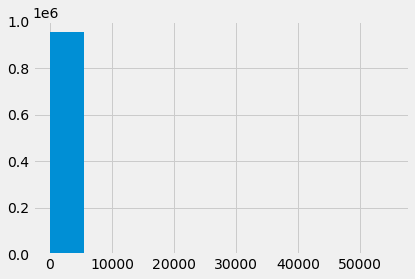

In [ ]:
# Lets now see a histogram of our trips in minute donation 

hist_bins = np.linspace(0, bike201912_df['duration_mins'].max(), num = 5)

bike201912_df['duration_mins'].hist();

The above histogram does not look right, we have some extreme outliers that throw off our histogram. 

In [ ]:
# Lets see what the max trip of our data is 

bike201912_df['duration_mins'].max()

# We may need to drop rows with extreme outliers This trip duration is over a week and unreasonable for our analysis

55071.02

In [ ]:
# Lets explore how much of our data are outliers. Lets see how many bike trips lasted over 24 hours. (24 hours = 1440 mins)

bike201912_df[bike201912_df['duration_mins'] > 1440].shape[0]

# there are 279 values I would consider extreme

279

In [ ]:
# Lets create a new df without those outliers 

bike201912_df_revised = bike201912_df[bike201912_df['duration_mins'] <= 1440]

# Check to see if we moved correct values difference between original dataframe and new dataframe should be 279

assert bike201912_df.shape[0] - bike201912_df_revised.shape[0] == 279

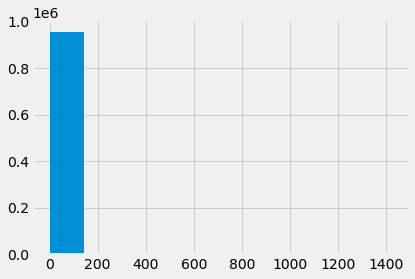

In [ ]:
# Now lets try exploring the histogram of trips again 

bike201912_df_revised['duration_mins'].hist();

# it looks like we still didn't narrow it down enough 

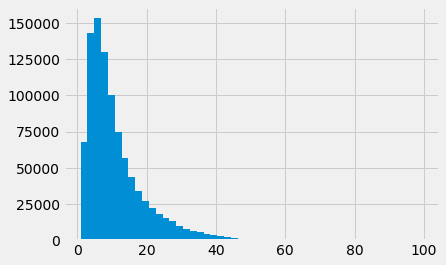

In [ ]:
# lets try a new dataframe 

bike201912_df[bike201912_df['duration_mins'] <= 100].duration_mins.hist(bins=50);

# This is looking better, almost like a log distribution 

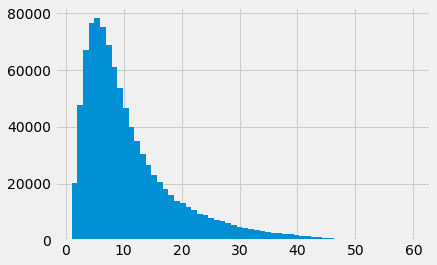

In [ ]:
# Narrow it down one more time 

bike201912_df[bike201912_df['duration_mins'] <= 60].duration_mins.hist(bins=60);

# it looks like capping our trup duration at 1 hour gives us the best data to use. Trips over an hour possible the riders may have stopped for lunch, or took a different route for one reason or another. 


In [ ]:
# Calculate the percentage of data that we are going to get rid of 

unwanted_data = round((bike201912_df[bike201912_df['duration_mins'] > 60].shape[0] / bike201912_df.shape[0])*100,2)

print('We will get rid of ' + str(unwanted_data)+'% of data that do not meet our requirement')

We will get rid of 0.53% of data that do not meet our requirement


In [ ]:
# Lets edit our revised dataframe one more time 

bike201912_df_revised = bike201912_df[bike201912_df['duration_mins'] <= 60]

# Lets assert we did it correct

assert bike201912_df.shape[0] - bike201912_df_revised.shape[0] == bike201912_df[bike201912_df['duration_mins'] > 60].shape[0]



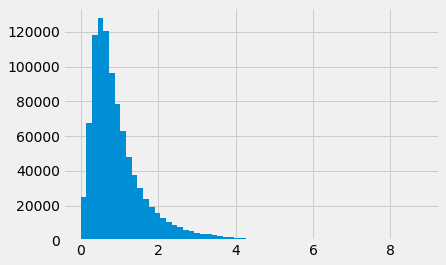

In [ ]:
# Now lets use our revised dataset to create a distrubution of the distance traveled 

bike201912_df_revised.distance_miles.hist(bins=60);

# This looks similar, and also looks like a log distritbution 

In [ ]:
# Code to look at head of the new dataframe

bike201912_df_revised.head()

,duration_seconds,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,duration_mins,distance_miles
0,602,2019-12-01 00:00:05.5640,2019-12-01 00:10:07.8180,3382,Carroll St & Smith St,40.680611,-73.994758,3304,6 Ave & 9 St,40.668127,-73.983776,41932,Subscriber,1970,1,10.02,1.036773
1,1206,2019-12-01 00:00:10.9630,2019-12-01 00:20:17.8820,362,Broadway & W 37 St,40.751726,-73.987535,500,Broadway & W 51 St,40.762288,-73.983362,18869,Customer,1999,1,20.06,0.760991
2,723,2019-12-01 00:00:11.8180,2019-12-01 00:12:14.8310,146,Hudson St & Reade St,40.716250,-74.009106,238,Bank St & Washington St,40.736197,-74.008592,15334,Subscriber,1997,1,12.03,1.376629
3,404,2019-12-01 00:00:12.2200,2019-12-01 00:06:56.8860,3834,Irving Ave & Halsey St,40.694670,-73.906630,3827,Halsey St & Broadway,40.685650,-73.915640,41692,Customer,1995,1,6.44,0.781876
4,1059,2019-12-01 00:00:14.7230,2019-12-01 00:17:54.1860,500,Broadway & W 51 St,40.762288,-73.983362,3323,W 106 St & Central Park West,40.798186,-73.960591,40156,Subscriber,1961,1,17.39,2.749951


## Scatterplot of Distance and Duration

Let us plot distance and duration together to see we can get a general sense if the assumption that the longer the distance, the higher the duration is true. 

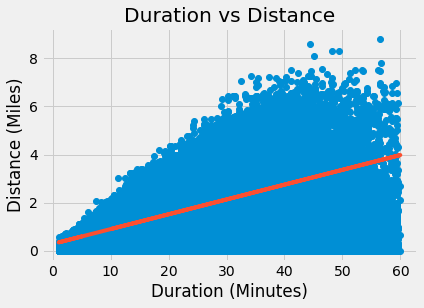

In [ ]:
# Let us use matplotlib to show if there is correleation between trip and distance 
# We will also add a simple linear regression line to see if there is a trend between the two 

from matplotlib import pyplot as plt

plt.plot(bike201912_df_revised.duration_mins, bike201912_df_revised.distance_miles, 'o')
m, b = np.polyfit(bike201912_df_revised.duration_mins, bike201912_df_revised.distance_miles, 1) 
plt.plot(bike201912_df_revised.duration_mins, m*bike201912_df_revised.duration_mins+b)
plt.title("Duration vs Distance")
plt.xlabel("Duration (Minutes)")
plt.ylabel("Distance (Miles)")
plt.show()

## Linear Regression of Distance and Duration

To see how well our trendline showed a relationship between the two variables, let us do a simple linear regression to see if the correlation holds up, or if there is too much variation to say the duration and distance influence each other

In [ ]:
# Let us test how well our regression fits the data 
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(bike201912_df_revised.duration_mins, bike201912_df_revised.distance_miles)

print("R =", r_value)
print("P =", p_value)

# It seems there is a positive correalation with Distance and Duration.  The P value is very small, so distance and duration have influence on each other and move in same direction. 

R = 0.7059612805676017
P = 0.0


## Conclusion

As we can see from our distrubutions a majority of Citi Bike Customers travel betwen 5-20 minutes and travel between 0.5-2 miles. They seem to follow a log distrubution, and heavily drop off quickly after 20 minutes and 2 miles. Not many people use the Bikes for long distance. 

Distance and duration move in the same direction and seem to influence each other, which would make sense. It is not a perfect relationship, as soon from our regression the correalation is strong, but not perfect. Traffic, time of day, etc could make a trip with the same distance longer or shorter. 

If we want to target a majority of the customer base with perhaps an incentive program based on how much they use Citi Bike, it would be best to target the customers using the bikes as described in our distributions. There would not be much value added working with programs that deal with long distance use of Citi Bike, since that is a small fraction of the trips taken

# **When do most people use City Bike?**

## Feature Engineering (date and time)

For analysis we want to extract the hour from the start and stop datetime. Then we use a frequency chart to see when most of Citi Bike customers use their bikes

In [ ]:
# Change 'starttime' and 'stoptime' data type to 'datetime' for easier data manipulation

bike201912_df_revised['starttime'] = pd.to_datetime( bike201912_df_revised['starttime'])
bike201912_df_revised['stoptime'] = pd.to_datetime( bike201912_df_revised['stoptime'])

# Extract the hour of the day from 'starttime' & 'stoptime' 

bike201912_df_revised['starttime_new'] = bike201912_df_revised['starttime'].dt.hour
bike201912_df_revised['stoptime_new'] = bike201912_df_revised['stoptime'].dt.hour

# Eye-ball test with the new features
bike201912_df_revised[['starttime','stoptime','starttime_new','stoptime_new']].head()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,starttime,stoptime,starttime_new,stoptime_new
0,2019-12-01 00:00:05.564,2019-12-01 00:10:07.818,0,0
1,2019-12-01 00:00:10.963,2019-12-01 00:20:17.882,0,0
2,2019-12-01 00:00:11.818,2019-12-01 00:12:14.831,0,0
3,2019-12-01 00:00:12.220,2019-12-01 00:06:56.886,0,0
4,2019-12-01 00:00:14.723,2019-12-01 00:17:54.186,0,0


## Frequency Chart of Trips Taken

Let's explore when are the busiest time for Citi Bike users during the day

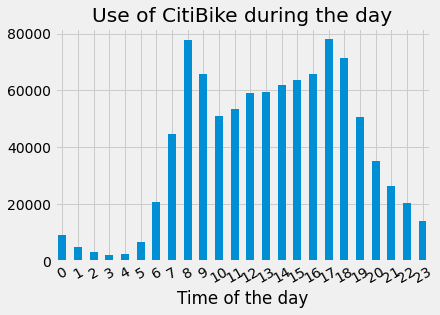

In [ ]:
# Create a plot to show number of bikes used in each hour

bike201912_df_revised.groupby('starttime_new').size().plot(kind = 'bar')
plt.title('Use of CitiBike during the day')
plt.xlabel('Time of the day')
plt.xticks(rotation=30)
plt.show()

# Hours from 7AM-9AM and 4PM-7PM are the busiest time for Citi bike 

## Feature Engineering (weekday/weekend)

We want to be able to see if a trip was on a weekday or weekend to see if consumer behavior changes whether its during the work week or on a weekend. We need to create a new feature to label a trip as weekday or weekend.

In [ ]:
# Check wether the day is on weekend or weekday. To do that, we use dayofweek function. If dayofweek < 5 -> weekday else weekend
bike201912_df_revised['day_of_week'] = np.where(bike201912_df_revised['starttime'].dt.dayofweek < 5, 'weekday','weekend')
bike201912_df_revised[['starttime','day_of_week']]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,starttime,day_of_week
0,2019-12-01 00:00:05.564,weekend
1,2019-12-01 00:00:10.963,weekend
2,2019-12-01 00:00:11.818,weekend
3,2019-12-01 00:00:12.220,weekend
4,2019-12-01 00:00:14.723,weekend
...,...,...
955205,2019-12-31 23:58:18.016,weekday
955206,2019-12-31 23:58:59.896,weekday
955207,2019-12-31 23:59:03.695,weekday
955208,2019-12-31 23:59:21.361,weekday


## Frequency Chart of weekdays vs weekends

We can place two histograms in one chart to visualize how Citi Bike is being used on weekdays vs weekends 

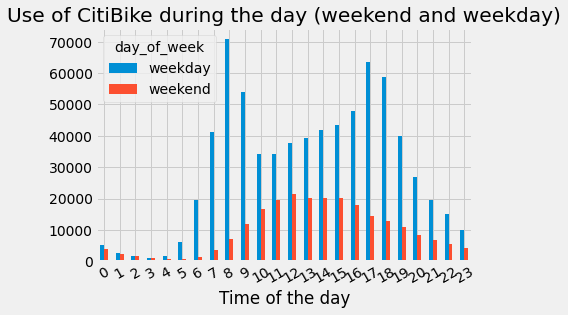

In [ ]:
# Plot to see the use of Citi bike during weekdays and weekends. 

bike201912_df_revised.groupby(['starttime_new','day_of_week']).size().unstack().plot(kind = 'bar')
plt.title('Use of CitiBike during the day (weekend and weekday)')
plt.xlabel('Time of the day')
plt.xticks(rotation=30)
plt.show()

# Clearly, on weekends, there are less trips. The peak hours on the weekend are also different. It seems there is no rush hour traffic on weekends

## Average Trips per Day (Weekend vs Weekday)

In [ ]:
# Lets see how may average trips per day are on weekdays compared to weekends

print("Average Trips per Day on a Weekday: ", len(bike201912_df_revised[bike201912_df_revised['day_of_week'] == 'weekday']['day_of_week']) / 5)
print("Average Trips per Day on a Weekend: ", len(bike201912_df_revised[bike201912_df_revised['day_of_week'] == 'weekend']['day_of_week']) / 2)

Average Trips per Day on a Weekday:  143168.6
Average Trips per Day on a Weekend:  117148.0


## Conclusion 

- Most people use Citi Bike during the daytime. During typical rush hours, there is a spike of Citi Bike usage. If we wanted to improve Citi Bike, it would be best to concentrate on these hours to see if quality of service holds up during busy commute times

- Weekdays are busier for Citi Bike than Weekends. As we thought before, people use Citi Bike different on Weekday than Weekends. On weekends most people use Citi Bike around Lunch time or mid afternoon. On weekdays most people use the service during rush hour

# Do Trips take longer during rush hour?

If Citi Bike wants to improve their service, it may be worth looking at whether during high usage time, quality of service goes down. Let us split up the data between rush hour and non rush hour and see how our data changes

## Dataset Slicing

First we need to slice our dataset and extract the rush hour trips from the rest of the data

In [ ]:
# Slice out weekends

rushhour_df = bike201912_df_revised[bike201912_df_revised['day_of_week'] == 'weekday']
non_rushhour_df = bike201912_df_revised[bike201912_df_revised['day_of_week'] == 'weekday']

# Slice out times not in rush hour 

rushhour_df = rushhour_df[ ((rushhour_df['starttime_new'] > 7) & (rushhour_df['starttime_new'] < 10)) | ((rushhour_df['starttime_new'] > 16) & (rushhour_df['starttime_new'] < 19)) ]
non_rushhour_df = non_rushhour_df[ ((non_rushhour_df['starttime_new'] < 8) | (non_rushhour_df['starttime_new'] > 9)) & ((non_rushhour_df['starttime_new'] < 17) | (non_rushhour_df['starttime_new'] > 18)) ]

In [ ]:
# Eyeball test our df has correct values

non_rushhour_df['starttime_new'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7, 10, 11, 12, 13, 14, 15, 16, 19, 20,
       21, 22, 23])

## Pivot Table comparison

In [ ]:
# Let us quick compare mean rush hour distance and duration with overall distance and duration during the weekday

import numpy as np


print(rushhour_df.groupby("day_of_week").agg({'duration_mins': np.mean, 'distance_miles': np.mean}))

print(non_rushhour_df.groupby("day_of_week").agg({'duration_mins': np.mean, 'distance_miles': np.mean}))

# It seems there is slight different of duration of trips during rush hour compared to not rush hour. Perhaps rush hour doest effect 

             duration_mins  distance_miles
day_of_week                               
weekday          11.113324        1.047255
             duration_mins  distance_miles
day_of_week                               
weekday          10.871586        0.937155


## Linear Regression of Rush Hour and Non Rush Hour dataset

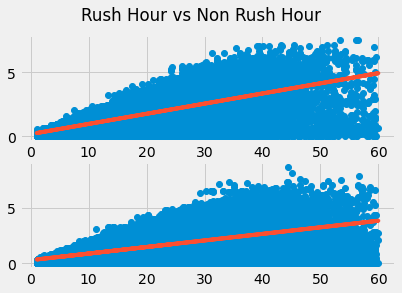

In [ ]:
# Lets run a scatter plot again to see if there is a difference. For this we will stack two scatterplots
# On top of each other and the trendline(regression) slope can show us if there is a difference. 

from matplotlib import pyplot as plt

fig, axs = plt.subplots(2)
fig.suptitle('Rush Hour vs Non Rush Hour')

axs[0].plot(rushhour_df.duration_mins, rushhour_df.distance_miles, 'o')
m, b = np.polyfit(rushhour_df.duration_mins, rushhour_df.distance_miles, 1) 
axs[0].plot(rushhour_df.duration_mins, m*rushhour_df.duration_mins+b)

axs[1].plot(non_rushhour_df.duration_mins, non_rushhour_df.distance_miles, 'o')
m, b = np.polyfit(non_rushhour_df.duration_mins, non_rushhour_df.distance_miles, 1) 
axs[1].plot(non_rushhour_df.duration_mins, m*non_rushhour_df.duration_mins+b)

plt.show()

In [ ]:
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(rushhour_df.duration_mins, rushhour_df.distance_miles)

print("Rush Hour")
print("R =", r_value)
print("P =", p_value)

slope, intercept, r_value, p_value, std_err = stats.linregress(non_rushhour_df.duration_mins, non_rushhour_df.distance_miles)

print("Non Rush Hour")
print("R =", r_value)
print("P =", p_value)

Rush Hour
R = 0.8046339428089558
P = 0.0
Non Rush Hour
R = 0.6859209203177227
P = 0.0


## Conclusion

During rush hour, the R value is higher, which means distance has more of an influence of duration. This could be caused by citi bike users not being able to go as fast as they want during traffic. So distance will be more of an indicator on how long a trip will take. 

For non rush hour, perhaps users are more free to ride as fast as the want to, so distance has influence, but less than that we see during rush hour. 

If Citi Bike wants to improve quality of service, they should investigate further on what causes increased trip duration vs distance during rush hour. Perhaps bike lanes should be improved, or stations should be more strategically placed. 

# What neighborhoods attract the most customers in NYC? 

To answer this question, we're going to assign a neighborhood to each bike station so we can do some analysis on which neighborhoods are the busiest for Citi Bike and so we can visualize the trips the users take. For this we will use a GeoPandas python library to figure out which neighborhood each station is in based on the provided longitude and latitude data

## Feature Engineering (Neighborhood)

In [ ]:
# Load NYC neighborhoods GeoJson data

nbhoods = gpd.read_file(
"https://data.beta.nyc/dataset/0ff93d2d-90ba-457c-9f7e-39e47bf2ac5f/resource/35dd04fb-81b3-479b-a074-a27a37888ce7/download/d085e2f8d0b54d4590b1e7d1f35594c1pediacitiesnycneighborhoods.geojson")
nbhoods.head()

,neighborhood,boroughCode,borough,@id,geometry
0,Allerton,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...,"POLYGON ((-73.84860 40.87167, -73.84582 40.870..."
1,Alley Pond Park,4,Queens,http://nyc.pediacities.com/Resource/Neighborho...,"POLYGON ((-73.74333 40.73888, -73.74371 40.739..."
2,Arden Heights,5,Staten Island,http://nyc.pediacities.com/Resource/Neighborho...,"POLYGON ((-74.16983 40.56108, -74.16982 40.561..."
3,Arlington,5,Staten Island,http://nyc.pediacities.com/Resource/Neighborho...,"POLYGON ((-74.15975 40.64142, -74.15998 40.641..."
4,Arrochar,5,Staten Island,http://nyc.pediacities.com/Resource/Neighborho...,"POLYGON ((-74.06078 40.59319, -74.06079 40.593..."


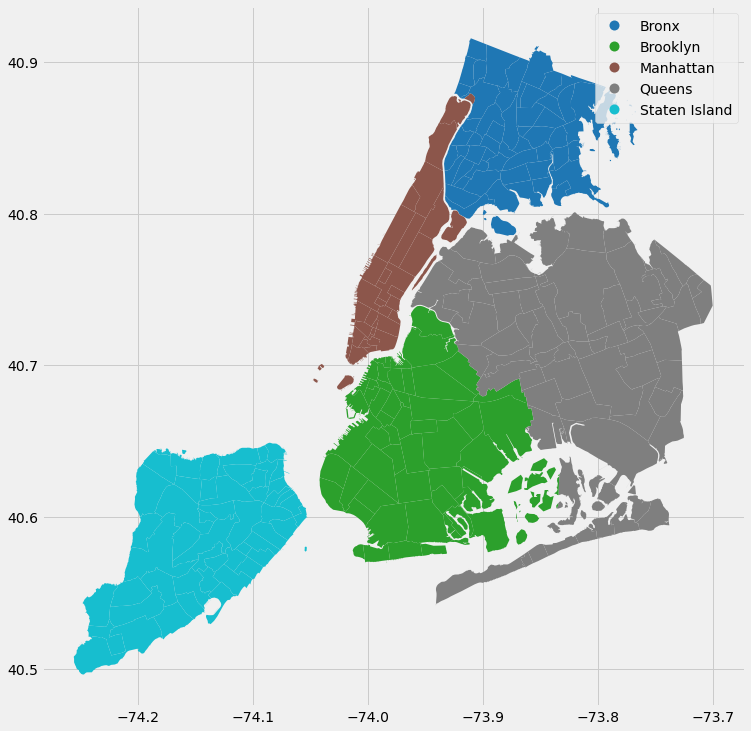

In [ ]:
# Plot the neighborhoods based on the boroughs 

fig, ax = plt.subplots(figsize=(15,12))
nbhoods.plot("borough", ax=ax, legend=True);

### Do CitiBike trips start and end at the same locations?


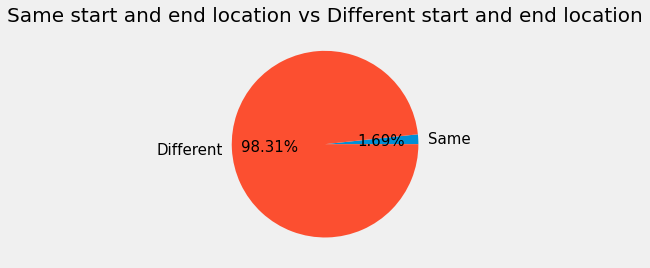

In [ ]:
#number of trips that started and ended at same station

start_end_same = bike201912_df_revised[bike201912_df_revised['start station name'] == bike201912_df_revised['end station name']].shape[0]

#number of trips that started and ended at different station

start_end_diff = bike201912_df_revised.shape[0]-start_end_same
plt.pie([start_end_same,start_end_diff],
        labels=['Same',
        'Different'],
        autopct='%1.2f%%',
        textprops={'fontsize': 15})
plt.title('Same start and end location vs Different start and end location', fontsize=20)
plt.show()

Since the majority of trips start and end in different locations, we will analyze the data in this section based on both start and end locations to see where the users are going from and to.

### Process bike data using start station location

In [ ]:
# Convert bike201912_df_revised to a GeoDataFrame using 'start station longitude' and 'start station latitude' so that later we can show boro and neighborhood names

bike201912_df_revised_gdf = gpd.GeoDataFrame(bike201912_df_revised,crs=('EPSG:4326'), 
                                             geometry=gpd.points_from_xy(bike201912_df_revised['start station longitude'], bike201912_df_revised['start station latitude']))
bike201912_df_revised_gdf.head()

# As we can see, now the geometry column with coordinate points is added to the df

,duration_seconds,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,duration_mins,distance_miles,starttime_new,stoptime_new,day_of_week,geometry
0,602,2019-12-01 00:00:05.564,2019-12-01 00:10:07.818,3382,Carroll St & Smith St,40.680611,-73.994758,3304,6 Ave & 9 St,40.668127,-73.983776,41932,Subscriber,1970,1,10.02,1.036773,0,0,weekend,POINT (-73.99476 40.68061)
1,1206,2019-12-01 00:00:10.963,2019-12-01 00:20:17.882,362,Broadway & W 37 St,40.751726,-73.987535,500,Broadway & W 51 St,40.762288,-73.983362,18869,Customer,1999,1,20.06,0.760991,0,0,weekend,POINT (-73.98754 40.75173)
2,723,2019-12-01 00:00:11.818,2019-12-01 00:12:14.831,146,Hudson St & Reade St,40.716250,-74.009106,238,Bank St & Washington St,40.736197,-74.008592,15334,Subscriber,1997,1,12.03,1.376629,0,0,weekend,POINT (-74.00911 40.71625)
3,404,2019-12-01 00:00:12.220,2019-12-01 00:06:56.886,3834,Irving Ave & Halsey St,40.694670,-73.906630,3827,Halsey St & Broadway,40.685650,-73.915640,41692,Customer,1995,1,6.44,0.781876,0,0,weekend,POINT (-73.90663 40.69467)
4,1059,2019-12-01 00:00:14.723,2019-12-01 00:17:54.186,500,Broadway & W 51 St,40.762288,-73.983362,3323,W 106 St & Central Park West,40.798186,-73.960591,40156,Subscriber,1961,1,17.39,2.749951,0,0,weekend,POINT (-73.98336 40.76229)


In [ ]:
# We want to make sure the CRS (Coordinate Reference System) matches between the nbhoods and bike201912_df_revised_gdf dataframes before joining them

assert(nbhoods.crs == bike201912_df_revised_gdf.crs)

In [ ]:
# We want to see the neighborhoods in our bike201912_df_revised_gdf so we are going to join bike201912_df_revised_gdf and nbhoods based on the locations using spatial join in geopandas

sjoined_nbhoods = gpd.sjoin(bike201912_df_revised_gdf,nbhoods, op='within').reset_index(drop=True)
sjoined_nbhoods.head()

,duration_seconds,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,duration_mins,distance_miles,starttime_new,stoptime_new,day_of_week,geometry,index_right,neighborhood,boroughCode,borough,@id
0,602,2019-12-01 00:00:05.564,2019-12-01 00:10:07.818,3382,Carroll St & Smith St,40.680611,-73.994758,3304,6 Ave & 9 St,40.668127,-73.983776,41932,Subscriber,1970,1,10.02,1.036773,0,0,weekend,POINT (-73.99476 40.68061),46,Carroll Gardens,3,Brooklyn,http://nyc.pediacities.com/Resource/Neighborho...
1,578,2019-12-01 00:00:33.212,2019-12-01 00:10:11.502,3382,Carroll St & Smith St,40.680611,-73.994758,3304,6 Ave & 9 St,40.668127,-73.983776,38966,Subscriber,1980,1,9.38,1.036773,0,0,weekend,POINT (-73.99476 40.68061),46,Carroll Gardens,3,Brooklyn,http://nyc.pediacities.com/Resource/Neighborho...
2,1205,2019-12-01 00:02:43.984,2019-12-01 00:22:49.514,3329,Degraw St & Smith St,40.682915,-73.993182,364,Lafayette Ave & Classon Ave,40.689004,-73.960239,39072,Subscriber,1969,1,20.05,1.780692,0,0,weekend,POINT (-73.99318 40.68292),46,Carroll Gardens,3,Brooklyn,http://nyc.pediacities.com/Resource/Neighborho...
3,129,2019-12-01 00:44:19.812,2019-12-01 00:46:28.951,3382,Carroll St & Smith St,40.680611,-73.994758,3332,Degraw St & Hoyt St,40.681990,-73.990790,18680,Subscriber,1992,1,2.09,0.229145,0,0,weekend,POINT (-73.99476 40.68061),46,Carroll Gardens,3,Brooklyn,http://nyc.pediacities.com/Resource/Neighborho...
4,668,2019-12-01 00:54:13.465,2019-12-01 01:05:21.896,3398,Smith St & 9 St,40.674696,-73.997858,157,Henry St & Atlantic Ave,40.690893,-73.996123,39798,Subscriber,1984,2,11.08,1.121331,0,1,weekend,POINT (-73.99786 40.67470),46,Carroll Gardens,3,Brooklyn,http://nyc.pediacities.com/Resource/Neighborho...


In [ ]:
# Let's drop some columns to make the df look cleaner

sjoined_nbhoods = sjoined_nbhoods.drop(columns=['index_right','boroughCode','@id'])
sjoined_nbhoods.head()

,duration_seconds,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,duration_mins,distance_miles,starttime_new,stoptime_new,day_of_week,geometry,neighborhood,borough
0,602,2019-12-01 00:00:05.564,2019-12-01 00:10:07.818,3382,Carroll St & Smith St,40.680611,-73.994758,3304,6 Ave & 9 St,40.668127,-73.983776,41932,Subscriber,1970,1,10.02,1.036773,0,0,weekend,POINT (-73.99476 40.68061),Carroll Gardens,Brooklyn
1,578,2019-12-01 00:00:33.212,2019-12-01 00:10:11.502,3382,Carroll St & Smith St,40.680611,-73.994758,3304,6 Ave & 9 St,40.668127,-73.983776,38966,Subscriber,1980,1,9.38,1.036773,0,0,weekend,POINT (-73.99476 40.68061),Carroll Gardens,Brooklyn
2,1205,2019-12-01 00:02:43.984,2019-12-01 00:22:49.514,3329,Degraw St & Smith St,40.682915,-73.993182,364,Lafayette Ave & Classon Ave,40.689004,-73.960239,39072,Subscriber,1969,1,20.05,1.780692,0,0,weekend,POINT (-73.99318 40.68292),Carroll Gardens,Brooklyn
3,129,2019-12-01 00:44:19.812,2019-12-01 00:46:28.951,3382,Carroll St & Smith St,40.680611,-73.994758,3332,Degraw St & Hoyt St,40.681990,-73.990790,18680,Subscriber,1992,1,2.09,0.229145,0,0,weekend,POINT (-73.99476 40.68061),Carroll Gardens,Brooklyn
4,668,2019-12-01 00:54:13.465,2019-12-01 01:05:21.896,3398,Smith St & 9 St,40.674696,-73.997858,157,Henry St & Atlantic Ave,40.690893,-73.996123,39798,Subscriber,1984,2,11.08,1.121331,0,1,weekend,POINT (-73.99786 40.67470),Carroll Gardens,Brooklyn


In [ ]:
# Create a new df to count values of neighborhood

grouped = sjoined_nbhoods['neighborhood'].value_counts()
nbh_df = grouped.reset_index()
nbh_df.columns = ['neighborhood','neighborhood_counts']
nbh_df.head()

,neighborhood,neighborhood_counts
0,Chelsea,95737
1,Midtown,87562
2,East Village,72175
3,Upper West Side,54622
4,Upper East Side,43282


In [ ]:
# Merge the new df back to sjoined_nbhoods 

bikedata_withcounts = sjoined_nbhoods.merge(nbh_df, on='neighborhood', how='outer')
bikedata_withcounts.head()

,duration_seconds,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,duration_mins,distance_miles,starttime_new,stoptime_new,day_of_week,geometry,neighborhood,borough,neighborhood_counts
0,602,2019-12-01 00:00:05.564,2019-12-01 00:10:07.818,3382,Carroll St & Smith St,40.680611,-73.994758,3304,6 Ave & 9 St,40.668127,-73.983776,41932,Subscriber,1970,1,10.02,1.036773,0,0,weekend,POINT (-73.99476 40.68061),Carroll Gardens,Brooklyn,6999
1,578,2019-12-01 00:00:33.212,2019-12-01 00:10:11.502,3382,Carroll St & Smith St,40.680611,-73.994758,3304,6 Ave & 9 St,40.668127,-73.983776,38966,Subscriber,1980,1,9.38,1.036773,0,0,weekend,POINT (-73.99476 40.68061),Carroll Gardens,Brooklyn,6999
2,1205,2019-12-01 00:02:43.984,2019-12-01 00:22:49.514,3329,Degraw St & Smith St,40.682915,-73.993182,364,Lafayette Ave & Classon Ave,40.689004,-73.960239,39072,Subscriber,1969,1,20.05,1.780692,0,0,weekend,POINT (-73.99318 40.68292),Carroll Gardens,Brooklyn,6999
3,129,2019-12-01 00:44:19.812,2019-12-01 00:46:28.951,3382,Carroll St & Smith St,40.680611,-73.994758,3332,Degraw St & Hoyt St,40.681990,-73.990790,18680,Subscriber,1992,1,2.09,0.229145,0,0,weekend,POINT (-73.99476 40.68061),Carroll Gardens,Brooklyn,6999
4,668,2019-12-01 00:54:13.465,2019-12-01 01:05:21.896,3398,Smith St & 9 St,40.674696,-73.997858,157,Henry St & Atlantic Ave,40.690893,-73.996123,39798,Subscriber,1984,2,11.08,1.121331,0,1,weekend,POINT (-73.99786 40.67470),Carroll Gardens,Brooklyn,6999


In [ ]:
# Check if the 2 dfs have the same amount of rows
assert(bikedata_withcounts.shape[0] == sjoined_nbhoods.shape[0])

So now we are done with data processing using start station, the df with neighborhood counts based on start stations is called 'bikedata_withcounts'. We're going to process data for end stations in following code blocks.

### Process bike data using end station location

In [ ]:
# Convert bike201912_df_revised to a GeoDataFrame using 'end station longitude' and 'end station latitude'

bike201912_df_revised_gdf1 = gpd.GeoDataFrame(bike201912_df_revised,crs=('EPSG:4326'), 
                                              geometry=gpd.points_from_xy(bike201912_df_revised['end station longitude'], bike201912_df_revised['end station latitude']))
bike201912_df_revised_gdf1.head()

,duration_seconds,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,duration_mins,distance_miles,starttime_new,stoptime_new,day_of_week,geometry
0,602,2019-12-01 00:00:05.564,2019-12-01 00:10:07.818,3382,Carroll St & Smith St,40.680611,-73.994758,3304,6 Ave & 9 St,40.668127,-73.983776,41932,Subscriber,1970,1,10.02,1.036773,0,0,weekend,POINT (-73.98378 40.66813)
1,1206,2019-12-01 00:00:10.963,2019-12-01 00:20:17.882,362,Broadway & W 37 St,40.751726,-73.987535,500,Broadway & W 51 St,40.762288,-73.983362,18869,Customer,1999,1,20.06,0.760991,0,0,weekend,POINT (-73.98336 40.76229)
2,723,2019-12-01 00:00:11.818,2019-12-01 00:12:14.831,146,Hudson St & Reade St,40.716250,-74.009106,238,Bank St & Washington St,40.736197,-74.008592,15334,Subscriber,1997,1,12.03,1.376629,0,0,weekend,POINT (-74.00859 40.73620)
3,404,2019-12-01 00:00:12.220,2019-12-01 00:06:56.886,3834,Irving Ave & Halsey St,40.694670,-73.906630,3827,Halsey St & Broadway,40.685650,-73.915640,41692,Customer,1995,1,6.44,0.781876,0,0,weekend,POINT (-73.91564 40.68565)
4,1059,2019-12-01 00:00:14.723,2019-12-01 00:17:54.186,500,Broadway & W 51 St,40.762288,-73.983362,3323,W 106 St & Central Park West,40.798186,-73.960591,40156,Subscriber,1961,1,17.39,2.749951,0,0,weekend,POINT (-73.96059 40.79819)


In [ ]:
# Check if the CRS for nbhoods and bike201912_df_revised_gdf1 are similar before joining

assert(nbhoods.crs == bike201912_df_revised_gdf1.crs)

In [ ]:
# Join bike201912_df_revised_gdf1 and nbhoods based on the locations using spatial join in geopandas

sjoined_nbhoods1 = gpd.sjoin(bike201912_df_revised_gdf1,nbhoods, op='within').reset_index(drop=True)
sjoined_nbhoods1.head()

,duration_seconds,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,duration_mins,distance_miles,starttime_new,stoptime_new,day_of_week,geometry,index_right,neighborhood,boroughCode,borough,@id
0,602,2019-12-01 00:00:05.564,2019-12-01 00:10:07.818,3382,Carroll St & Smith St,40.680611,-73.994758,3304,6 Ave & 9 St,40.668127,-73.983776,41932,Subscriber,1970,1,10.02,1.036773,0,0,weekend,POINT (-73.98378 40.66813),214,Park Slope,3,Brooklyn,http://nyc.pediacities.com/Resource/Neighborho...
1,578,2019-12-01 00:00:33.212,2019-12-01 00:10:11.502,3382,Carroll St & Smith St,40.680611,-73.994758,3304,6 Ave & 9 St,40.668127,-73.983776,38966,Subscriber,1980,1,9.38,1.036773,0,0,weekend,POINT (-73.98378 40.66813),214,Park Slope,3,Brooklyn,http://nyc.pediacities.com/Resource/Neighborho...
2,147,2019-12-01 00:13:29.707,2019-12-01 00:15:56.898,3373,3 St & 3 Ave,40.675071,-73.987752,3368,5 Ave & 3 St,40.672816,-73.983524,28714,Subscriber,1961,2,2.27,0.271230,0,0,weekend,POINT (-73.98352 40.67282),214,Park Slope,3,Brooklyn,http://nyc.pediacities.com/Resource/Neighborho...
3,367,2019-12-01 00:18:00.618,2019-12-01 00:24:08.507,3429,Hanson Pl & Ashland Pl,40.685068,-73.977908,3368,5 Ave & 3 St,40.672816,-73.983524,35241,Subscriber,1977,1,6.07,0.895445,0,0,weekend,POINT (-73.98352 40.67282),214,Park Slope,3,Brooklyn,http://nyc.pediacities.com/Resource/Neighborho...
4,435,2019-12-01 00:26:15.657,2019-12-01 00:33:31.560,3419,Douglass St & 4 Ave,40.679279,-73.981540,3404,7 St & 5 Ave,40.670492,-73.985417,31172,Subscriber,1992,1,7.15,0.639584,0,0,weekend,POINT (-73.98542 40.67049),214,Park Slope,3,Brooklyn,http://nyc.pediacities.com/Resource/Neighborho...


In [ ]:
# Let's drop some columns to make the df look cleaner

sjoined_nbhoods1 = sjoined_nbhoods1.drop(columns=['index_right','boroughCode','@id'])
sjoined_nbhoods1.head()

,duration_seconds,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,duration_mins,distance_miles,starttime_new,stoptime_new,day_of_week,geometry,neighborhood,borough
0,602,2019-12-01 00:00:05.564,2019-12-01 00:10:07.818,3382,Carroll St & Smith St,40.680611,-73.994758,3304,6 Ave & 9 St,40.668127,-73.983776,41932,Subscriber,1970,1,10.02,1.036773,0,0,weekend,POINT (-73.98378 40.66813),Park Slope,Brooklyn
1,578,2019-12-01 00:00:33.212,2019-12-01 00:10:11.502,3382,Carroll St & Smith St,40.680611,-73.994758,3304,6 Ave & 9 St,40.668127,-73.983776,38966,Subscriber,1980,1,9.38,1.036773,0,0,weekend,POINT (-73.98378 40.66813),Park Slope,Brooklyn
2,147,2019-12-01 00:13:29.707,2019-12-01 00:15:56.898,3373,3 St & 3 Ave,40.675071,-73.987752,3368,5 Ave & 3 St,40.672816,-73.983524,28714,Subscriber,1961,2,2.27,0.271230,0,0,weekend,POINT (-73.98352 40.67282),Park Slope,Brooklyn
3,367,2019-12-01 00:18:00.618,2019-12-01 00:24:08.507,3429,Hanson Pl & Ashland Pl,40.685068,-73.977908,3368,5 Ave & 3 St,40.672816,-73.983524,35241,Subscriber,1977,1,6.07,0.895445,0,0,weekend,POINT (-73.98352 40.67282),Park Slope,Brooklyn
4,435,2019-12-01 00:26:15.657,2019-12-01 00:33:31.560,3419,Douglass St & 4 Ave,40.679279,-73.981540,3404,7 St & 5 Ave,40.670492,-73.985417,31172,Subscriber,1992,1,7.15,0.639584,0,0,weekend,POINT (-73.98542 40.67049),Park Slope,Brooklyn


In [ ]:
# create a new df to count values of neighborhood

grouped1 = sjoined_nbhoods1['neighborhood'].value_counts()
nbh_df1 = grouped1.reset_index()
nbh_df1.columns = ['neighborhood','neighborhood_counts']
nbh_df1.head()

,neighborhood,neighborhood_counts
0,Chelsea,97375
1,Midtown,88000
2,East Village,70638
3,Upper West Side,49389
4,Upper East Side,43021


In [ ]:
# merge the new df back to sjoined_nbhoods 

bikedata_withcounts1 = sjoined_nbhoods1.merge(nbh_df1, on='neighborhood', how='outer')
bikedata_withcounts1.head()

,duration_seconds,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,duration_mins,distance_miles,starttime_new,stoptime_new,day_of_week,geometry,neighborhood,borough,neighborhood_counts
0,602,2019-12-01 00:00:05.564,2019-12-01 00:10:07.818,3382,Carroll St & Smith St,40.680611,-73.994758,3304,6 Ave & 9 St,40.668127,-73.983776,41932,Subscriber,1970,1,10.02,1.036773,0,0,weekend,POINT (-73.98378 40.66813),Park Slope,Brooklyn,12646
1,578,2019-12-01 00:00:33.212,2019-12-01 00:10:11.502,3382,Carroll St & Smith St,40.680611,-73.994758,3304,6 Ave & 9 St,40.668127,-73.983776,38966,Subscriber,1980,1,9.38,1.036773,0,0,weekend,POINT (-73.98378 40.66813),Park Slope,Brooklyn,12646
2,147,2019-12-01 00:13:29.707,2019-12-01 00:15:56.898,3373,3 St & 3 Ave,40.675071,-73.987752,3368,5 Ave & 3 St,40.672816,-73.983524,28714,Subscriber,1961,2,2.27,0.271230,0,0,weekend,POINT (-73.98352 40.67282),Park Slope,Brooklyn,12646
3,367,2019-12-01 00:18:00.618,2019-12-01 00:24:08.507,3429,Hanson Pl & Ashland Pl,40.685068,-73.977908,3368,5 Ave & 3 St,40.672816,-73.983524,35241,Subscriber,1977,1,6.07,0.895445,0,0,weekend,POINT (-73.98352 40.67282),Park Slope,Brooklyn,12646
4,435,2019-12-01 00:26:15.657,2019-12-01 00:33:31.560,3419,Douglass St & 4 Ave,40.679279,-73.981540,3404,7 St & 5 Ave,40.670492,-73.985417,31172,Subscriber,1992,1,7.15,0.639584,0,0,weekend,POINT (-73.98542 40.67049),Park Slope,Brooklyn,12646


In [ ]:
# Check if the 2 dfs have the same amount of rows

assert(bikedata_withcounts1.shape[0] == sjoined_nbhoods.shape[0])

We are done processing data using end station, the df with neighborhood counts based on end stations is called 'bikedata_withcounts1'

## What are the busiest neighborhoods in Manhattan for Citi Bike? 

For Citi Bike to see which neighborhoods account for the most Citi Bike trips we can create a heat map showing where most Citi Bike trips originate from and stop at by station and neighborhood

### What boroughs are CitiBike available?
Let's first see what boroughs CitiBike are avaiable

Text(0.5, 1.0, 'CitiBike End Locations by NYC Boroughs')

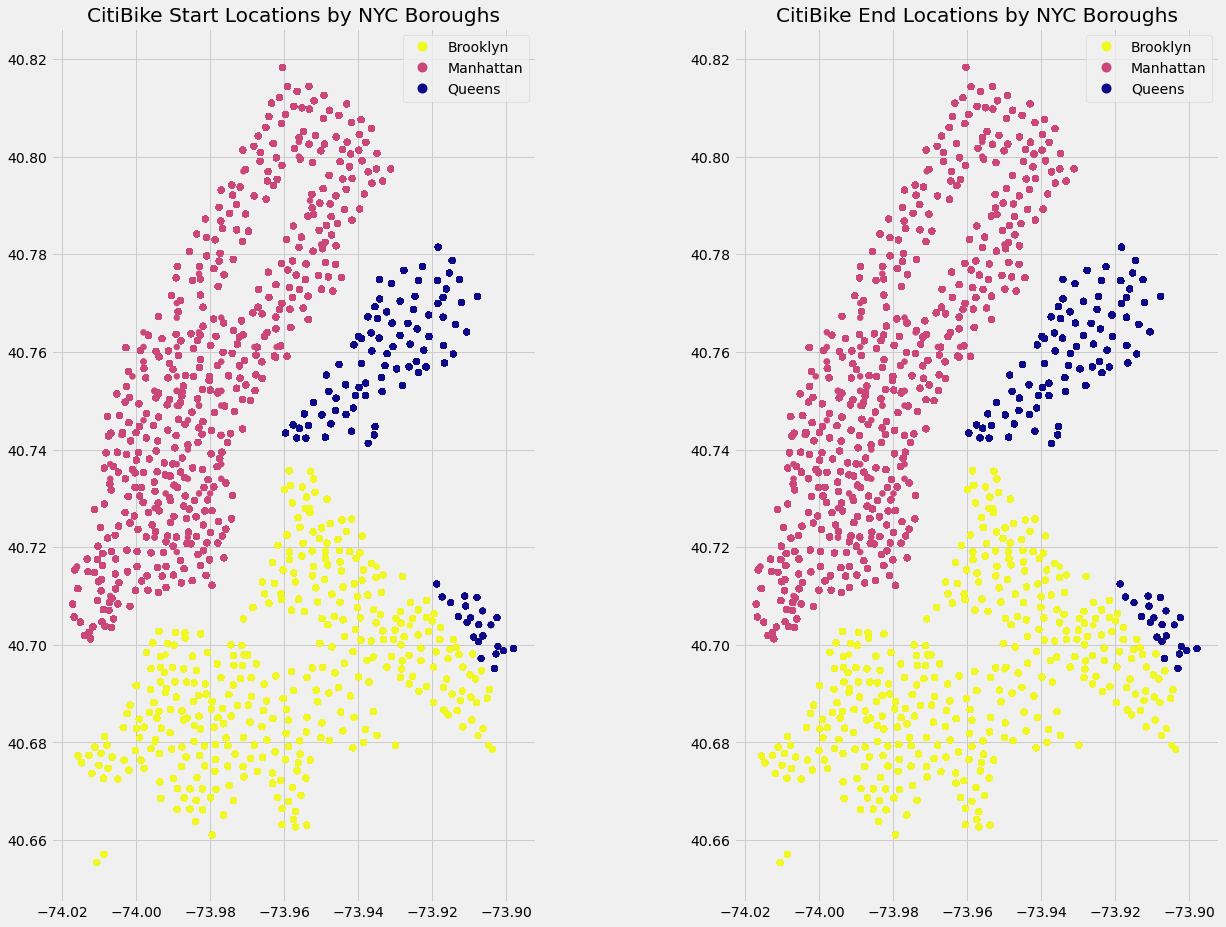

In [ ]:
# Plot CitiBike use in NYC Boroughs
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(20,15))

bikedata_withcounts.plot("borough", cmap='plasma_r',ax=ax1, legend=True)
ax1.set_title('CitiBike Start Locations by NYC Boroughs')

bikedata_withcounts1.plot("borough", cmap='plasma_r',ax=ax2, legend=True)
ax2.set_title('CitiBike End Locations by NYC Boroughs')


As Citibike were available in Brooklyn, Manhattan and Queens by December 2019, our data also shows the 3 boroughs. We're going to set active neighborhoods in these 3 boroughs in the following code block.

In [ ]:
# Create a new neighborhood df with active boroughs
active_nbhoods = ['Brooklyn','Manhattan','Queens']

nbhoods_new = nbhoods[nbhoods['borough'].isin(active_nbhoods)]
nbhoods_new.head()

,neighborhood,boroughCode,borough,@id,geometry
1,Alley Pond Park,4,Queens,http://nyc.pediacities.com/Resource/Neighborho...,"POLYGON ((-73.74333 40.73888, -73.74371 40.739..."
5,Arverne,4,Queens,http://nyc.pediacities.com/Resource/Neighborho...,"POLYGON ((-73.78953 40.59997, -73.78954 40.599..."
6,Astoria,4,Queens,http://nyc.pediacities.com/Resource/Neighborho...,"POLYGON ((-73.90160 40.76777, -73.90270 40.766..."
7,Bath Beach,3,Brooklyn,http://nyc.pediacities.com/Resource/Neighborho...,"POLYGON ((-73.99381 40.60195, -73.99962 40.596..."
8,Battery Park City,1,Manhattan,http://nyc.pediacities.com/Resource/Neighborho...,"POLYGON ((-74.01375 40.71369, -74.01426 40.710..."


### What neighborhoods in NYC does Citibike have high amount of users?
We're going to plot a map based on the Citibike use in each neighborhood. 

In [ ]:
fig,(ax1, ax2) = plt.subplots(ncols=2,figsize=(20,15))

base1 = nbhoods_new.plot(color='white', edgecolor='grey', ax=ax1)
base2 = nbhoods_new.plot(color='white', edgecolor='grey', ax=ax2)

bikedata_withcounts.plot(column='neighborhood_counts', cmap ='plasma_r', ax=base1, legend=True)
ax1.set_title("CitiBike Start Locations by NYC Neighborhoods")

bikedata_withcounts1.plot(column='neighborhood_counts', cmap ='plasma_r', ax=base2, legend=True)
ax2.set_title("CitiBike End Locations by NYC Neighborhoods")

plt.show()

The darker the color, the busier the neighborhood is. The neighborhood's busyness are pretty much similar between start and end locations. 

### Let's look in details the popular neighborhoods for start and end locations

In [ ]:
#Get top 20 stations 
top_start_station = nbh_df[:11]
top_end_station = nbh_df1[:11]


fig, (ax1,ax2)=plt.subplots(ncols=2,figsize=(20,15))
ax1.bar(x=top_start_station['neighborhood'], height=top_start_station['neighborhood_counts'], color='#70eb67', width=0.5)
ax2.bar(x=top_end_station['neighborhood'], height=top_end_station['neighborhood_counts'], color='#edde68', width=0.5)

#adding value above each bar:Annotation
for p in ax1.patches:
    an1 = ax1.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center',
                   va = 'center', 
                   xytext = (0, 10), 
                   textcoords = 'offset points')
    an1.set_size(10)

for p in ax2.patches:
    an2 = ax2.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center',
                   va = 'center', 
                   xytext = (0, 10), 
                   textcoords = 'offset points')
    an2.set_size(10)


ax1.set_title("Top 20 start locations in NY",fontsize=30)
ax1.set_xlabel("Start Station name",fontsize=20)

ax2.set_title("Top 20 end locations in NY",fontsize=30)
ax2.set_xlabel("End Station name",fontsize=20)


#rotating the x tick labels to 45 degrees
ax1.set_xticklabels(top_start_station['neighborhood'], rotation = 45, ha="right")
ax1.set_ylabel("Count",fontsize=20)

ax2.set_xticklabels(top_end_station['neighborhood'], rotation = 45, ha="right")
ax2.set_ylabel("Count",fontsize=20)

#tweeking x and y tick labels 
ax1.tick_params(labelsize=15)
ax2.tick_params(labelsize=15)


##Conclusion
- There are a high volumn of trips at Chelsea stations, close to 100,000 trip a month. Followed by Midtown and East Village stations, with aroud 90,000 and 70,000 trips respectively. 
- CitiBike can roll out incentive programs to make sure these neighborhood always have enough bikes for customers, especially during rush hours during weekdays. 
 - Incentive programs could be customers would earn rewards for returning bikes in the busy neightborhoods prior to and during the rush hours. Or the customers would earn rewards for bringing bikes from a full station to an empty one in one of the busy neighborhoods
- For CitiBike customers, always check the availability of bikes in the busy neighborhoods before heading to the station. Take advantage of the incentive programs from CitiBike to earn more rewards for future free rides. And if you can, avoid these neighborhood during rush hours. 

# Who are CitiBike Customers? 

Now let us discover who Citibike customers are and what do they have in common?

## Subscribers or Customers?
CitiBike has 2 type of users: **Customers** are the users who purchase 24-hour pass or 3-day pass and **Subscribers** are the annual member.

In [ ]:
# Plot a pie chart to show the ratio of users
user_type = bikedata_withcounts['usertype'].value_counts()
plt.pie(user_type.values,
        labels = user_type.index,
        autopct = '%1.2f%%',
        textprops={'fontsize': 15})
plt.title('Subscribers vs. Customers', fontsize=20)
plt.show()

## How old are they?


### Feature Engineering
We will discover how old the users are and will group them in a new age group based on generation. 

In [ ]:
# See what are the user' birth year 
birth_year = bikedata_withcounts['birth year'].unique()
birth_year.sort()
birth_year

It doesn't look right that someone was born in the 1800s was still alive, let alone riding the bike! For this analysis, we are going to assume users who were born earlier than 1945 (older than 75 years old) do not ride the bike, due to health and weather condition. Hence, we will assume birth years that are smaller than 1945 are bad data. We're going to use this [article](https://www.pewresearch.org/fact-tank/2019/01/17/where-millennials-end-and-generation-z-begins/) as a resource to group the generation based on birth years in the following:

```python
if birth year < 1945: print('Bad data (>75yo)')
elif 1946 < birth year < 1964: print('Baby Boomer (56-74yo)')
elif 1965 < birth year < 1980: print('Gen X (40-55yo)')
elif 1981 < birth year < 1996: print('Millennials (24-39yo)')
else: print('Gen Z (17-23)')
```

In [ ]:
# create a new age group
bikedata_withcounts['gen'] = pd.cut(bikedata_withcounts['birth year'],[1885,1946,1964,1980,1996,2003],
                                     labels=['Bad data (>75)', 'Boomer (56-74)', 'Gen X (40-55)', 'Millennials (24-39)', 'Gen Z(17-23)'])
bikedata_withcounts[['gen','birth year']].head()
                                     

###Plot

In [ ]:
# historgram of age group
plt.subplots(figsize=(8,6))
bikedata_withcounts['gen'].value_counts().plot(kind = 'bar', rot = 45)
plt.ylabel("Frequency")
plt.title('Distribution of CitiBike Use in Each Age Group')
plt.xlabel('Age Group')
plt.show()

The plot shows that millenials from 24 to 39 years old are the top CitiBike users, follwoing by Gen X (40-55 years old).

In [ ]:
# Average trip duration per age group 

avg_tripdur = bikedata_withcounts.groupby('gen').agg({'duration_mins':'mean'}).sort_values(by='duration_mins', ascending=False)
avg_tripdur

In [ ]:
# Plot it
avg_tripdur.plot(kind='bar', legend = None, rot = 45)
plt.ylabel("Frequency")
plt.title('Distribution of Trip Duration in Each Age Group')
plt.xlabel('Age Group')
plt.rcParams["figure.figsize"] = [10,8]
plt.show()

In [ ]:
# Average distance miles per generation

avg_dist = bikedata_withcounts.groupby('gen').agg({'distance_miles':'mean'}).sort_values(by = 'distance_miles', ascending = False)
avg_dist

In [ ]:
# Plot it

avg_dist.plot(kind='bar', legend = None, rot = 45)
plt.ylabel("Frequency")
plt.title('Distribution of Trip Distance in Each Age Group')
plt.xlabel('Age Group')
plt.rcParams["figure.figsize"] = [10,8]
plt.show()


There are not too much difference in the average trip duration and average trip distance among all age groups. 

## Genders

In [ ]:
bikedata_withcounts['gender_new'] = bikedata_withcounts['gender'].apply(lambda x: 'F' if x ==2 else 'M' if x ==1 else 'Unknown' )
bikedata_withcounts[['gender', 'gender_new']].head()

In [ ]:
sns.countplot(x='gen',hue='gender_new',data = bikedata_withcounts)
plt.xlabel('Age group')
plt.ylabel('Freq.')
plt.xticks(rotation=45);

## Conclusion
- Top CitiBike customers are millenials from the age of 24 to 39 males. They ride around 11 minutes and less than 1 mile each trip. Our assumption is these individuals use CitiBike for commuting purposes. 
- The individuals who are least likely to ride CitiBike are Gen Z, who are under 23 years old. Understandably that this age group might still be in school, CitiBike does have room for improvement in this group. They can have an incentive program (for example, buy a pass get a free pass, etc.) to build a customer base. So that when this group becomes older and need a mean of transportation to commute, they would think about CitiBike first.   

# **Wrap-up: Lessons learned and technical challenges**

**Lesson Learned**: Python is a powerful tool in analyzing data; we have learned to use various packages within Python to help us in the project. Besides the common ones such as Pandas and Numpy, we got to experience using Matplotlib and Seaborn to help us with data visualizations. We also got to use GeoPy and GeoPandas to help us get the distances and locations.

We also learned that besides knowing how to write code and create pretty visualizations, it's important as a data analyst to build a powerful story based on the results we get. 

**Technical Challenges**: We did have to refer to prior class assingments and outside sources to look for what we wanted to do. And since our data is relatively large, it usually took a long time to load and run the data/code. And had the time  permitted, we would have also looked into analyzing the data for the whole year or recent years. 